In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os
%matplotlib inline  

def create_paired_dataset(input_file, output_file=None, label=None):
    # Load the original matrix
    x = np.load(input_file)
    if label == 0:
        y = np.zeros(x.shape[0], dtype=int)
    elif label == 1:
        y = np.ones(x.shape[0], dtype=int)
    
    # Create the paired dataset
    paired_dataset = (x, y)
    
    # Optionally save the paired dataset
    if output_file:
        np.save(output_file, paired_dataset)
    
    return paired_dataset

def get_accuracy(layers=None, activations_dir=None):
    accuracy = []
    for layer in layers:
        cautious_x, cautious_y = create_paired_dataset(os.path.join(activations_dir, f"deepseek_layer_{layer}_cautious_activations.npy"), label=0)
        non_cautious_x, non_cautious_y = create_paired_dataset(os.path.join(activations_dir, f"deepseek_layer_{layer}_noncautious_activations.npy"), label=1)
        X = np.vstack((cautious_x, non_cautious_x))
        y = np.concatenate((cautious_y, non_cautious_y))

        # Create a permutation of indices
        shuffle_indices = np.random.permutation(len(y))
        # Use these indices to shuffle both X and y in the same way
        X = X[shuffle_indices]
        y = y[shuffle_indices]

        # 5. Split into train and test sets (75% train, 25% test)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42, stratify=y
        )

        # print(f"Training set size: {X_train.shape[0]} samples")
        # print(f"Test set size: {X_test.shape[0]} samples")
        # print(f"Feature vector size: {X_train.shape[1]} dimensions")
        # print(f"Class distribution in training: {np.bincount(y_train)}")
        # print(f"Class distribution in testing: {np.bincount(y_test)}")
        # Train a logistic regression classifier
        clf = LogisticRegression(max_iter=1000, random_state=42)
        clf.fit(X_train, y_train)

        # Evaluate the model
        y_pred = clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))

    return accuracy

In [4]:
layers = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31]
baseline_dir = "../activations/baseline/"
cot150_dir = "../activations/cot150/"
baseline_variations = []
cot150_variations = []
for x in range(10):
    baseline_variations.append(get_accuracy(layers, baseline_dir))
    cot150_variations.append(get_accuracy(layers, cot150_dir))
baseline_mean = np.mean(baseline_variations, axis=0)
cot150_mean = np.mean(cot150_variations, axis=0)
baseline_std = np.std(baseline_variations, axis=0)
cot150_std = np.std(cot150_variations, axis=0)

print(baseline_mean)
print(cot150_mean)

[0.7        0.7195122  0.67560976 0.71219512 0.73170732 0.79756098
 0.75121951 0.76829268 0.8        0.77804878 0.79268293 0.8
 0.78780488 0.78292683 0.8097561  0.76829268]
[0.75365854 0.77317073 0.83658537 0.82439024 0.87317073 0.88780488
 0.82926829 0.88292683 0.91707317 0.88292683 0.87560976 0.87560976
 0.84878049 0.8902439  0.85609756 0.89756098]


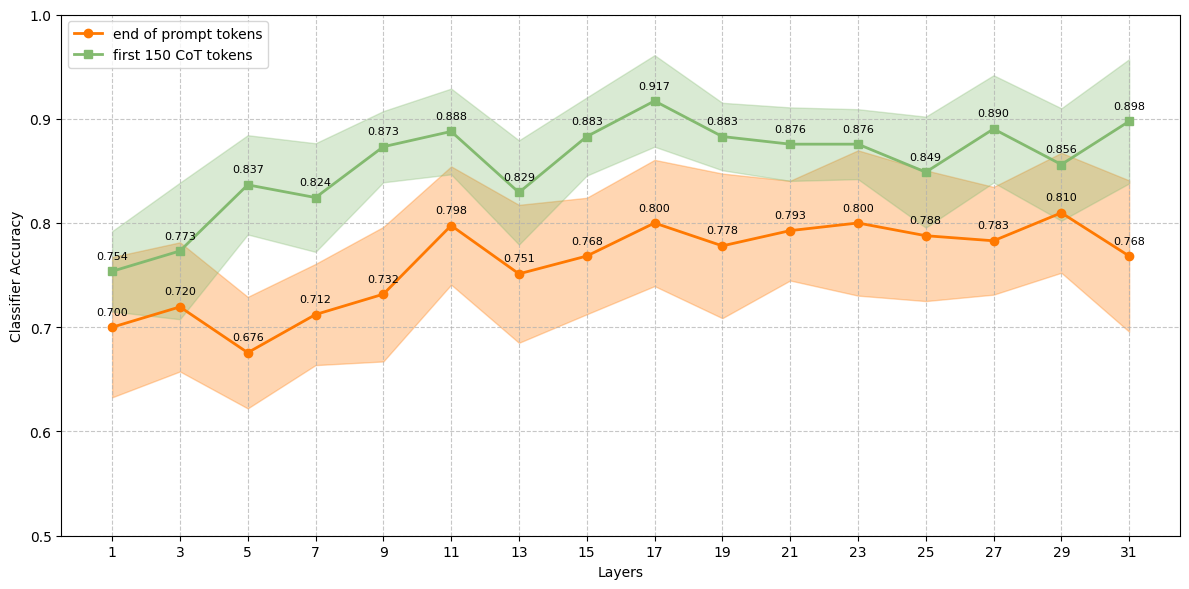

In [5]:
import numpy as np

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create x-axis values (assuming layers is a list of layer names/numbers)
x = np.arange(len(layers))

# Plot the lines
line1 = ax.plot(x, baseline_mean, label='end of prompt tokens', color='#ff7901', linewidth=2, marker='o', markersize=6)
line2 = ax.plot(x, cot150_mean, label='first 150 CoT tokens', color='#83ba6f', linewidth=2, marker='s', markersize=6)

# Add shaded regions for standard deviation
ax.fill_between(x, 
                np.array(baseline_mean) - np.array(baseline_std), 
                np.array(baseline_mean) + np.array(baseline_std), 
                color='#ff7901', alpha=0.3)

ax.fill_between(x, 
                np.array(cot150_mean) - np.array(cot150_std), 
                np.array(cot150_mean) + np.array(cot150_std), 
                color='#83ba6f', alpha=0.3)

# Add labels, title and custom x-axis tick labels
ax.set_xlabel('Layers')
ax.set_ylabel('Classifier Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(layers)

# Set y-axis range to highlight differences
ax.set_ylim([0.5, 1.0])

# Add a grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Add a legend
ax.legend()

# Add value annotations at each point
for i, v in enumerate(baseline_mean):
    ax.text(x[i], v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8, color='black')

for i, v in enumerate(cot150_mean):
    ax.text(x[i], v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8, color='black')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig('../figures/classifier_accuracy_comparison4.png', dpi=300)
plt.show()